# Construction and Electrophysiological Simulation of Thalamic Neuron Models

This example demonstrates how to implement thalamic neuron models using the `braincell` framework, including four typical thalamic neuron types: `HTC`, `RTC`, `IN`, and `TRN`.
By constructing these neurons with complex combinations of ion channels, you will learn how to simulate the electrophysiological properties of thalamic neurons and understand the functional significance of differences in channel composition among neuron types.

## Preparation
First, ensure that the necessary libraries (`braincell`, `brainstate`, `brainunit`, `matplotlib`) are installed, and import the required modules:


In [22]:
import time  # 用于记录模拟耗时

import brainstate
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import braincell

## Code Explanation

### Base Class for Thalamic Neurons

Define a base class for all thalamic neurons, encapsulating common functionalities:


In [23]:
class ThalamusNeuron(braincell.SingleCompartment):
    def compute_derivative(self, I_ext=0. * u.nA):
        I_ext = self.sum_current_inputs(I_ext, self.V.value) * self.area
        for key, ch in self.nodes(braincell.IonChannel, allowed_hierarchy=(1, 1)).items():
            I_ext = I_ext + ch.current(self.V.value)
        self.V.derivative = I_ext / self.C
        for key, node in self.nodes(braincell.IonChannel, allowed_hierarchy=(1, 1)).items():
            node.compute_derivative(self.V.value)

    def step_run(self, t, inp):
        # Define update rule at each time step
        with brainstate.environ.context(t=t):
            self.update(inp)
            return self.V.value


### Implementation of Four Thalamic Neuron Types

In the thalamus, different neuron types achieve distinct functions through specific combinations of ion channels. The following describes their channel composition:

#### HTC


In [24]:
class HTC(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm **2),  # Potassium leak channel conductance
        V_initializer=braintools.init.Constant(-65. * u.mV),  # Initial membrane potential
        solver: str = 'ind_exp_euler'  # Integration method
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        # Membrane area parameter
        self.area = 1e-3 / (2.9e-4 * u.cm** 2)

        # Sodium channel
        self.na = braincell.ion.SodiumFixed(size, E=50. * u.mV)  # Sodium reversal potential 50 mV
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-30 * u.mV))

        # Potassium channel
        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)  # Potassium reversal potential -90 mV
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))  # Potassium leak current
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-30. * u.mV, phi=0.25))  # Delayed rectifier potassium current

        # Calcium channel
        self.ca = braincell.ion.CalciumDetailed(
            size,
            C_rest=5e-5 * u.mM,  # Resting calcium concentration
            tau=10. * u.ms,  # Calcium decay time constant
            d=0.5 * u.um  # Calcium diffusion distance
        )
        self.ca.add(ICaL=braincell.channel.ICaL_IS2008(size, g_max=0.5 * (u.mS / u.cm **2)))  # L-type calcium channel
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.5 * (u.mS / u.cm** 2)))  # N-type calcium channel
        self.ca.add(ICaT=braincell.channel.ICaT_HM1992(size, g_max=2.1 * (u.mS / u.cm **2)))  # T-type calcium channel (low-threshold)
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=3.0 * (u.mS / u.cm** 2)))  # High-threshold calcium channel

        # Calcium-activated potassium channel (IAHP)
        self.kca = braincell.MixIons(self.k, self.ca)  # Mix potassium and calcium ions
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.3 * (u.mS / u.cm **2)))

        # Hyperpolarization-activated cation current (Ih) and leak current (IL)
        self.Ih = braincell.channel.Ih_HM1992(size, g_max=0.01 * (u.mS / u.cm** 2), E=-43 * u.mV)  # Regulates resting potential and rhythm
        self.IL = braincell.channel.IL(size, g_max=0.0075 * (u.mS / u.cm **2), E=-70 * u.mV)  # Background leak current


#### RTC

In [25]:
class RTC(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm** 2),
        V_initializer=braintools.init.Constant(-65. * u.mV),
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20 * u.mV, solver=solver)

        self.area = 1e-3 / (2.9e-4 * u.cm **2)  # Membrane area parameter

        # Sodium channel
        self.na = braincell.ion.SodiumFixed(size)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-40 * u.mV))

        # Potassium channel
        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-40 * u.mV, phi=0.25))  # Gating shift
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))

        # Calcium channel
        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaL=braincell.channel.ICaL_IS2008(size, g_max=0.3 * (u.mS / u.cm** 2)))
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.6 * (u.mS / u.cm **2)))
        self.ca.add(ICaT=braincell.channel.ICaT_HM1992(size, g_max=2.1 * (u.mS / u.cm** 2)))
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=0.6 * (u.mS / u.cm **2)))

        # Calcium-activated potassium channel (IAHP)
        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.1 * (u.mS / u.cm** 2)))

        # Ih and IL currents
        self.Ih = braincell.channel.Ih_HM1992(size, g_max=0.01 * (u.mS / u.cm **2), E=-43 * u.mV)
        self.IL = braincell.channel.IL(size, g_max=0.0075 * (u.mS / u.cm** 2), E=-70 * u.mV)


#### IN

In [26]:
class IN(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm **2),
        V_initializer=braintools.init.Constant(-70. * u.mV),  # More hyperpolarized initial membrane potential
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        self.area = 1e-3 / (1.7e-4 * u.cm** 2)

        # Sodium channel
        self.na = braincell.ion.SodiumFixed(size)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-30 * u.mV))

        # Potassium channel
        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-30 * u.mV, phi=0.25))
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))

        # Calcium channel
        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.1 * (u.mS / u.cm **2)))
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=2.5 * (u.mS / u.cm** 2)))

        # Calcium-activated potassium channel (IAHP)
        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.2 * (u.mS / u.cm **2)))

        # Leak (IL) and hyperpolarization-activated current (Ih)
        self.IL = braincell.channel.IL(size, g_max=0.0075 * (u.mS / u.cm** 2), E=-60 * u.mV)
        self.Ih = braincell.channel.Ih_HM1992(size, g_max=0.05 * (u.mS / u.cm **2), E=-43 * u.mV)


#### TRN

In [27]:
class TRN(ThalamusNeuron):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm** 2),
        V_initializer=braintools.init.Constant(-70. * u.mV),
        gl=0.0075,  # Leak conductance coefficient
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        self.area = 1e-3 / (1.43e-4 * u.cm **2)

        # Sodium channel
        self.na = braincell.ion.SodiumFixed(size)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-40 * u.mV))

        # Potassium channel
        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-40 * u.mV))
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))

        # Calcium channel
        self.ca = braincell.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=100. * u.ms, d=0.5 * u.um)
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.2 * (u.mS / u.cm** 2)))
        self.ca.add(ICaT=braincell.channel.ICaT_HP1992(size, g_max=1.3 * (u.mS / u.cm **2)))

        # Calcium-activated potassium channel (IAHP)
        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.2 * (u.mS / u.cm** 2)))

        # Leak current (IL)
        self.IL = braincell.channel.IL(size, g_max=gl * (u.mS / u.cm **2), E=-60 * u.mV)


### Simulating Thalamic Neuron Electrical Activity

Define the `try_trn_neuron` function to set input currents, simulation parameters, run the simulation, and visualize the results:


Simulation elapsed time: 1.4482 seconds


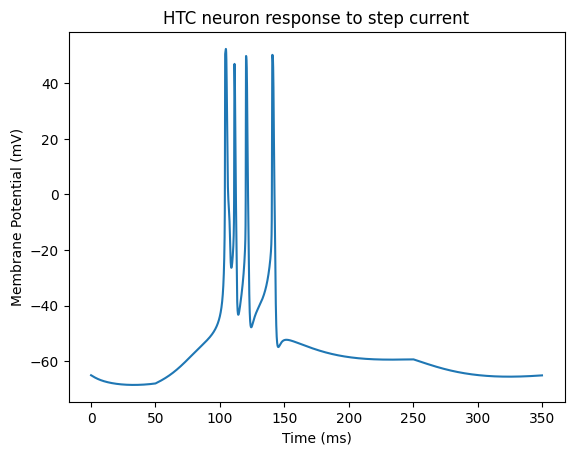

In [28]:
def try_trn_neuron():
    # Set the simulation time step
    brainstate.environ.set(dt=0.02 * u.ms)

    # Generate stepwise input current
    I = braintools.input.section(
        values=[0, 0.05, 0],  # Current amplitudes
        durations=[50 * u.ms, 200 * u.ms, 100 * u.ms]  # Duration of each segment
    ) * u.uA

    # Generate simulation time series
    times = u.math.arange(I.shape[0]) * brainstate.environ.get_dt()

    # Select the neuron type to simulate (HTC here; can be replaced with RTC, IN, TRN)
    neu = HTC(1, solver='ind_exp_euler')  # Use independent exponential Euler method
    neu.init_state()  # Initialize neuron state

    # Run the simulation and record elapsed time
    t0 = time.time()
    vs = brainstate.transform.for_loop(neu.step_run, times, I)  # Loop to update neuron state
    t1 = time.time()
    print(f"Simulation elapsed time: {t1 - t0:.4f} seconds")  # Output computation time

    # Visualize membrane potential changes
    plt.plot(
        times.to_decimal(u.ms),  # x-axis: time
        u.math.squeeze(vs.to_decimal(u.mV))  # y-axis: membrane potential
    )
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.title('HTC neuron response to step current')
    plt.show()


# Execute the simulation
if __name__ == '__main__':
    try_trn_neuron()


## Results Interpretation

After running the code, you will obtain the membrane potential trace of an HTC neuron under step current stimulation. Typical characteristics are as follows:

- 0–50 ms (no current): The neuron remains at rest, with a stable membrane potential around -65 mV, maintained by the balance of leak current and Ih current.

- 50–250 ms (0.05 uA current injection):
   - The injected current depolarizes the membrane, reaching threshold and triggering action potentials.
   - Due to the involvement of T-type calcium channels and IAHP currents, burst firing may occur, which is a hallmark of thalamic neurons participating in rhythmic oscillations.

- 250–350 ms (current off):
   - The membrane potential gradually returns to the resting level, but afterhyperpolarization may appear due to the sustained action of calcium-activated potassium channels.

## Extended Exercises

- Replace the neuron type, e.g., `neu = TRN(1)`, to compare how TRN and HTC neurons respond to the same current.
- Modify the conductance of T-type calcium channels, e.g., `ICaT_HM1992(g_max=1.0 * ...)`, to observe its effect on burst firing.
- Extend the simulation time and analyze the spontaneous rhythmic activity of different thalamic neuron types.

Through these exercises, you will gain a deeper understanding of thalamic neuron electrophysiological properties and their role in regulating brain rhythms.
